<a href="https://colab.research.google.com/github/ksun0401/musinsa_recommend/blob/master/%EA%B8%B0%EA%B3%84%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### 환경: colab pro
## 의류 이미지 분류와 Grad-CAM을 이용한 영역 모델 해석
> 진행 순서
>> 모델 3개 선정 -> 모델 결정 -> Grad-CAM으로 해석


In [66]:
# 한글 폰트 세팅
%matplotlib inline  

import matplotlib as mpl 
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

NanumBarunGothic


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
import os
import numpy as np
import pandas as pd
from glob import glob
import random

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import font_manager, rc

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
import torchvision

from torchvision import transforms
import albumentations as A
from albumentations import Compose
from albumentations.pytorch import ToTensorV2
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
import re
from tqdm import tqdm

import gc
import torch

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import f1_score, precision_score

import warnings  
warnings.filterwarnings(action = 'ignore')

print(A.__version__)
!nvidia-smi

1.2.1
Tue Nov 22 05:11:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    33W /  70W |   9082MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-

In [68]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda', index=0)

In [69]:
seed = 42

os.environ['PYTHONHASHSEED'] = str(seed)

random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

In [70]:
df = pd.read_csv("/content/drive/MyDrive/data/musinsa_high/musinsa.csv", index_col = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53890 entries, 0 to 53889
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    53890 non-null  object
 1   label   53890 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ MB


In [71]:
df.head()

,path,label
0,/content/drive/MyDrive/data/musinsa_high/musin...,0
1,/content/drive/MyDrive/data/musinsa_high/musin...,0
2,/content/drive/MyDrive/data/musinsa_high/musin...,0
3,/content/drive/MyDrive/data/musinsa_high/musin...,0
4,/content/drive/MyDrive/data/musinsa_high/musin...,0


In [72]:
# 데이터를 0.01배 샘플링하여 빠른 실험 진행

# df_small = df.sample(frac=0.01)
# df_small.info()

In [73]:
# 의류 이름 컬럼 생성을 위해 path에서 이름만 추출

def re_h(x):
    x = re.compile('[a-zA-Z0-9/_.]').sub('', x).strip()
    return x

def cut_label(x):
    x = x[:int(len(x)/2)]
    return x

In [74]:
# 각 label의 개수 확인
# 크게 unbalance하지는 않다.

df['name'] = df['path'].apply(re_h).apply(cut_label)
df['name'].value_counts()

긴팔티               2070
레깅스                2070
후드티                 2070
트레이닝팬츠         2070
플리스                2070
코튼팬츠             2070
코치(나일론)재킷    2070
카라티                 2070
숏패딩               2070
슬랙스               2070
숏팬츠               2070
블루종               2070
블레이저재킷         2070
반팔티               2070
맨투맨               2070
데님팬츠             2070
니트스웨터             2070
기타바지               2070
가디건                2070
후드집업             2070
트러커재킷            2042
기타상의              1945
환절기코트           1803
겨울코트              1721
레더재킷              1674
트레이닝재킷         1313
무스탕                 724
롱패딩                674
바시티재킷             594
Name: name, dtype: int64

In [75]:
# fig = plt.figure(figsize = (15, 15)),
# label_count = df['label'].value_counts()
# label_count
# label_count = df['name'].value_counts()

# sns.barplot(x = df['name'], y = df['name'].value_counts())

In [76]:
# custom_dataset 생성

class Custom_Dataset(Dataset):
    def __init__(self, x, y = None, transforms = None):
        self.x = x
        self.y = y
        self.transforms = transforms
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):

        img = Image.open(self.x[idx]).convert("RGB") # RGB로 변환
        img = np.array(img)
        label = self.y[idx]

        if self.transforms:
            img = self.transforms(image = img)
            img = img['image']
            
        return img, label

In [77]:
train_val_transform = A.Compose([
    A.Resize(256, 256),
    # A.CenterCrop(224, 224, always_apply=True, p=1.0),
    A.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225)),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(256, 256),
    # A.CenterCrop(224, 224, always_apply=True, p=1.0),
    A.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225)),
    ToTensorV2()
])

### train-val-test(8:1:1) 나누기
>train: 43112 <br>
>validation: 5389 <br>
>test: 5389 <br>

In [78]:
x_train, x_test, y_train, y_test = train_test_split(df['path'], df['label'],
                                                  test_size = 0.2, shuffle = True,
                                                  stratify = df['label'], random_state = 42)

x_val, x_test, y_val, y_test = train_test_split(x_test, y_test,
                                                  test_size = 0.5, shuffle = True,
                                                  stratify = y_test, random_state = 42)

x_train = list(x_train)
x_val = list(x_val)
y_train = list(y_train)
y_val = list(y_val)
x_test = list(x_test)
y_test = list(y_test)

In [79]:
# x_train, x_test, y_train, y_test = train_test_split(df_small['path'], df_small['label'],
#                                                   test_size = 0.3, shuffle = True,
#                                                   stratify = df_small['label'], random_state = 42)

# x_val, x_test, y_val, y_test = train_test_split(x_test, y_test,
#                                                   test_size = 0.5, shuffle = True,
#                                                   random_state = 42)

# x_train = list(x_train)
# x_val = list(x_val)
# y_train = list(y_train)
# y_val = list(y_val)
# x_test = list(x_test)
# y_test = list(y_test)

In [80]:
# train: 43112
# val: 5389
# test: 5389

print(f'x_train: {len(x_train)}, y_train: {len(y_train)}\nx_val: {len(x_val)}, y_val: {len(y_val)}\nx_test: {len(x_test)}, y_test: {len(y_test)}')

x_train: 43112, y_train: 43112
x_val: 5389, y_val: 5389
x_test: 5389, y_test: 5389


In [81]:
# DataLoader
# 배치 사이즈: 64
# train만 shuffle 허용

train_dataset = Custom_Dataset(x_train, y_train, transforms = train_val_transform)
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True, drop_last = True, num_workers=6)

val_dataset = Custom_Dataset(x_val, y_val, transforms = train_val_transform)
val_loader = DataLoader(val_dataset, batch_size = 64, shuffle = False, drop_last = True, num_workers=6)

test_dataset = Custom_Dataset(x_test, y_test, transforms = test_transform)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False, drop_last = True, num_workers=0)

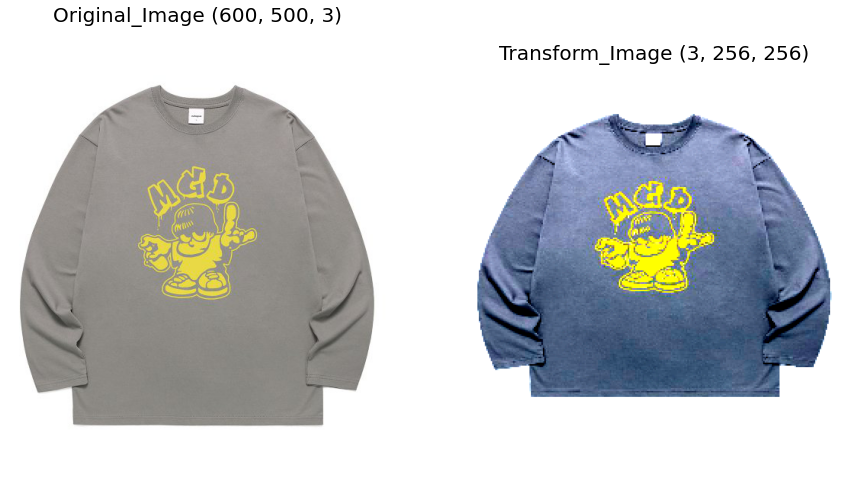

In [82]:
# 원본 이미지와 transform 된 이미지 비교

fig = plt.figure(figsize=(15, 15))
def custom_imshow(img_transform, img):

    img_transform = img_transform.numpy()
    
    ax1 = fig.add_subplot(1, 2, 1)
    plt.imshow(img)
    ax1.set_title('Original_Image (600, 500, 3)', size = 20)
    ax1.axis("off")

    ax2 = fig.add_subplot(1, 2, 2)
    plt.imshow(np.transpose(img_transform, (1, 2, 0))) 
    ax2.set_title('Transform_Image (3, 256, 256)', size = 20)
    ax2.axis("off")
    plt.show()

img = Image.open(df.path[12]).convert('RGB')
img = np.array(img)
img_transform = train_val_transform(image = img)
img_transform = img_transform['image']

custom_imshow(img_transform, img)

In [ ]:
# EarlyStopping 구현

class EarlyStopping:
    def __init__(self, patience, verbose = False, delta = 0):
        self.patience = patience
        self.verbose = verbose
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.counter = 0
        self.delta = delta
        self.path = '/content/drive/MyDrive/data/save_data/best_model.pth' 

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
            
    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).\n Saving model ...\n')
            torch.save(model.state_dict(), self.path)
            self.val_loss_min = val_loss
            

In [ ]:
# train셋 학습

def train(model, optimizer, epoch, scheduler, device):
    model = model.to(device)
    early_stopping = EarlyStopping(patience = 5, verbose = True) 

    train_losses, val_losses = [], [] # train, val loss 리스트로 저장

    for epoch in range(epoch):
        print(f"\n------ {epoch} epoch -------\n")
        model.train()
        train_loss_list = []
        train_loss = 0.0
        
        for img, label in tqdm(iter(train_loader)):  # Dataloader에 저장된 데이터들이 배치 단위로  나온다.
            img, label = img.to(device), label.to(device)

            optimizer.zero_grad()    # 0으로 초기화
            pred = model(img)
            loss = criterion(pred, label)

            loss.backward()     # gradient 계산
            optimizer.step()    # 파라미터 업데이트

            train_loss_list.append(loss.item())

        if scheduler is not None: 
            scheduler.step()    


        model.eval()
        val_loss = 0.0
        val_loss_list = []
        model_preds = []
        true_labels = []

        correct = 0
        
        # validation으로 평가 
        with torch.no_grad():
            for img, label in tqdm(iter(val_loader)):
                img, label = img.to(device), label.to(device)
                
                val_pred = model(img)
                v_loss = criterion(val_pred, label)

                val_loss_list.append(v_loss.item()) 

                model_preds += val_pred.argmax(1).detach().cpu().numpy().tolist()  # 예측값 추출
                true_labels += label.detach().cpu().numpy().tolist() # 실제값 추출
                
                pred = val_pred.argmax(dim=1, keepdim=True)  
                correct += pred.eq(label.view_as(pred)).sum().item() # 맞춘 개수 
        
        # epoch 당 평균 loss 값 
        train_lossed = np.mean(train_loss_list) 
        val_lossed = np.mean(val_loss_list)

        # epoch 당 모든 평균 loss 리스트로 저장
        train_losses.append(train_lossed)
        val_losses.append(val_lossed)

        # 평가 지표 accuracy, precision, f1_score 선정
        val_accuracy = 100 * correct / len(val_loader.dataset)
        precision = precision_score(true_labels, model_preds, average = 'micro')
        f1 = f1_score(true_labels, model_preds, average = "weighted")

        print(f"\nTrain loss: {train_lossed:.4f}")
        print(f"Val Loss: {val_lossed:.4f}")
        print(f"precsion ------> {precision:.5f}")
        print(f"f1_score ------> {f1:.5f}")
        print(f"{correct} / {len(val_loader.dataset)}, Accuracy: {val_accuracy:.3f}%\n")

        # early_stopping을 통해 오버 피팅 방지
        early_stopping(val_lossed, model)
        if early_stopping.early_stop:
            print('Early Stopping')
            break

        model.load_state_dict(torch.load('/content/drive/MyDrive/data/save_data/best_model.pth'))
    return train_losses, val_losses # 저장된 loss history 리턴
   

In [ ]:
# test셋 평가

def predict(model, test_loader, device):
    model.load_state_dict(torch.load('/content/drive/MyDrive/data/save_data/best_model.pth'), strict = False)

    model.to(device)
    model.eval()  # test eval 
    model_pred = []
    true_labels = []
    correct = 0
    
    with torch.no_grad():
        for img, label in tqdm(iter(test_loader)):
            img, label = img.to(device), label.to(device)
            
            test_pred = model(img)

            model_pred += test_pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += label.detach().cpu().numpy().tolist()

            pred = test_pred.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()
        
    test_accuracy = 100 * correct / len(test_loader.dataset)
    precision = precision_score(true_labels, model_pred, average = 'micro')
    f1 = f1_score(true_labels, model_pred, average = "weighted")

    print(f"\nprecsion ------> {precision:.5f}")
    print(f"f1_score ------> {f1:.5f}")
    print(f"{correct} / {len(test_loader.dataset)}, Accuracy: {test_accuracy:.3f}%\n")

In [ ]:
class ResNet50(nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()
        self.model = torchvision.models.resnet50(pretrained = True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 29)
    
    def forward(self, x):
        return self.model(x)

class MobilenetV2(nn.Module):
    def __init__(self):
        super(MobilenetV2, self).__init__()
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
        self.drop = nn.Dropout(p = 0.3)
        self.model.classifier[1] = nn.Linear(1280, 29)

    def forward(self, x):
        x = self.drop(x)
        return self.model(x)


class Efficientnet(nn.Module):
    def __init__(self):
        super(Efficientnet, self).__init__()
        self.model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
        self.drop = nn.Dropout(p = 0.3)
        self.model.classifier.fc = nn.Linear(1280, 29)
    
    def forward(self, x):
        x = self.drop(x)
        return self.model(x)

In [ ]:
# 메모리 캐시 정리

gc.collect()
torch.cuda.empty_cache()

### resnet, mobilenet, efficientnet 3개의 모델로 테스트
> loss: CrossEntropy <br>
> Optimizer: AdamW <br>
> learning rate: 0.001

>> best 정확도, 1 epoch 당 시간  
>> resnet: 71%, 9분 <br>
>> mobilenet: 64%, 4분 <br>
>> efficietnet: 64%, 4분 56초  <br>


In [ ]:
criterion = nn.CrossEntropyLoss()

resnet = ResNet50() 
mobilenet = MobilenetV2() 
efficientnet = Efficientnet() 

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [ ]:
resnet_optimizer = optim.Adam(params = resnet.parameters(), lr = 0.001)
resnet_scheduler = optim.lr_scheduler.LambdaLR(resnet_optimizer, lr_lambda = lambda epoch:0.95**epoch,
                                        last_epoch = -1, verbose = False)

train_loss, val_loss = train(resnet, resnet_optimizer, 20, resnet_scheduler, device)


------ 0 epoch -------



 15%|█▍        | 98/673 [01:21<08:00,  1.20it/s]


KeyboardInterrupt: ignored

In [ ]:
# train , val loss 시각화

fig = plt.figure(figsize = (8, 8))
plt.plot(train_loss, marker = 'o', label='train_loss')
plt.plot(val_loss, marker = 'o', label='val_loss')
plt.legend()
plt.title('train vs valid')

In [ ]:
predict(resnet, test_loader, device)

In [ ]:
mobilenet_optimizer = optim.Adam(params = mobilenet.parameters(), lr = 0.001)
scheduler = optim.lr_scheduler.LambdaLR(mobilenet_optimizer, lr_lambda = lambda epoch:0.95**epoch,
                                         last_epoch = -1, verbose = False)

train_loss, val_loss = train(mobilenet, mobilenet_optimizer, 20, scheduler, device)

In [ ]:
# train , val loss 시각화

fig = plt.figure(figsize = (8, 8))
plt.plot(train_loss, marker = 'o', label='train_loss')
plt.plot(val_loss, marker = 'o', label='val_loss')
plt.legend()
plt.title('train vs valid')

In [ ]:
predict(mobilenet, test_loader, device)

In [ ]:
efficientnet_optimizer = optim.Adam(params = efficientnet.parameters(), lr = 0.001)
efficientnet_scheduler = optim.lr_scheduler.LambdaLR(efficientnet_optimizer, lr_lambda = lambda epoch:0.95**epoch,
                                                     last_epoch = -1, verbose = False)
    
train_loss, val_loss = train(efficientnet, efficientnet_optimizer, 20, efficientnet_scheduler, device)

In [ ]:
# train , val loss 시각화

fig = plt.figure(figsize = (8, 8))
plt.plot(train_loss, marker = 'o', label='train_loss')
plt.plot(val_loss, marker = 'o', label='val_loss')
plt.legend()
plt.title('train vs valid')

In [ ]:
predict(efficientnet, test_loader, device)

In [ ]:
# 마지막 convolution layer
# 분류 부분 파라미터 추출
final_conv = mobilenet.model.features[18]
print(final_conv)
fc_params = list(mobilenet.model.classifier.parameters())

## 성능이 가장 좋았던 resnet을 통해 Grad-CAM 시각화 진행 중
> 목표하고자 하는 것
>> 정답과 오답을 나누어 5개 씩 히트맵 확인

In [ ]:
class SaveFeatures():
    """ Extract pretrained activations"""
    features = None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()
    def remove(self):
        self.hook.remove()


# def getCAM(feature_conv, weight_fc, class_idx, cur_images):
#     _, nc, h, w = feature_conv.shape

#     cam = weight_fc[class_idx].dot(feature_conv[0, :, :, ].reshape((nc, h*w)))
#     # print(cam)
#     fig = plt.figure(figsize=(30, 30))
#     # cam = cam[0, :].reshape(h, w)
#     # cam = cam - np.min(cam)
#     # cam_img = cam / np.max(cam)
#     # print(cam_img.shape)
#     for i in range(10):
#         cam = weight_fc[class_idx].dot(feature_conv[0, :, :, ].reshape((nc, h*w)))
#         cam = cam[i, :].reshape(h, w)
#         cam = cam - np.min(cam)
#         cam_img = cam / np.max(cam)
#         # cam_img = cam_img.astype(np.uint16)
        
#         ax = fig.add_subplot(1, 10, i+1, xticks=[], yticks=[])
#         plt.imshow(cv2.cvtColor(cur_images[i], cv2.COLOR_BGR2RGB))
#         plt.imshow(cv2.resize(cam_img, (224, 224), interpolation=cv2.INTER_LINEAR), alpha=0.4, cmap='jet')
#         ax.set_title('Label:%d, Predict:%d' % (target, pred_idx), fontsize=14)
#         # return cam_img



def plotGradCAM(model, final_conv, fc_params, train_loader, 
                row=1, col=10, img_size=224, device='cpu', original=False):
    for param in model.parameters():
        param.requires_grad = False
    
    model.load_state_dict(torch.load('/content/drive/MyDrive/data/save_data/best_model.pth'), strict = False)
    model.to(device)
    model.eval()
    # save activated_features from conv
    activated_features = SaveFeatures(final_conv)
    # save weight from fc
    weight = np.squeeze(fc_params[0].cpu().data.numpy())
    # original images
    # heatmap images

    # fig = plt.figure(figsize=(10, 10))
    for i, (img, target) in enumerate(test_loader):
        output = model(img.to(device))
        pred_idx = output.to('cpu').numpy().argmax(1)
        cur_images = img.cpu().numpy().transpose((0, 2, 3, 1))

        # getCAM(activated_features.features, weight, pred_idx, cur_images)

        _, nc, h, w = activated_features.features.shape # chanel, height, width 언패킹

        # cam = weight[pred_idx].dot(activated_features.features[0, :, :, ].reshape((nc, h*w)))
        # print(cam)
        fig = plt.figure(figsize=(30, 30))
        # cam = cam[0, :].reshape(h, w)
        # cam = cam - np.min(cam)
        # cam_img = cam / np.max(cam)
        # print(cam_img.shape)
        for i in range(5):
            cam = weight[pred_idx].dot(activated_features.features[0, :, :, ].reshape((nc, h*w)))
            cam = cam[i, :].reshape(h, w)
            cam = cam - np.min(cam)
            cam_img = cam / np.max(cam)
            # cam_img = cam_img.astype(np.uint16)
            ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
            plt.imshow(cv2.cvtColor(cur_images[i], cv2.COLOR_BGR2RGB))
            plt.imshow(cv2.resize(cam_img, (224, 224), interpolation=cv2.INTER_LINEAR), alpha=0.4, cmap='jet')
            # ax.set_title('Label:%s, Predict:%s'% (df['name'].unique()[target[i]], df['name'].unique()[pred_idx[i]]), fontsize=14)
            ax.set_title('Label:%d, Predict:%d'% (target[i], pred_idx[i]), fontsize=14)
        # heatmap = getCAM(activated_features.features, weight, pred_idx)
        # ax = fig.add_subplot(row, col, i+1, xticks=[], yticks=[])

        # plt.imshow(cv2.cvtColor(cur_images[0], cv2.COLOR_BGR2RGB))
        # plt.imshow(cv2.resize(heatmap, (img_size, img_size), interpolation=cv2.INTER_LINEAR), alpha=0.4, cmap='jet')
        # ax.set_title('Label:%d, Predict:%d' % (target, pred_idx), fontsize=14)
        if i == row*col-1:
            break
    plt.show()

In [ ]:
plotGradCAM(mobilenet, final_conv, fc_params, test_loader)

In [ ]:
class SaveFeatures():
    """ Extract pretrained activations"""
    features = None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()
    def remove(self):
        self.hook.remove()



def getCAM(feature_conv, weight_fc, class_idx, cur_images):
    _, nc, h, w = feature_conv.shape

    cam = weight_fc[class_idx].dot(feature_conv[0, :, :, ].reshape((nc, h*w)))
    # print(cam)
    fig = plt.figure(figsize=(30, 30))
    # cam = cam[0, :].reshape(h, w)
    # cam = cam - np.min(cam)
    # cam_img = cam / np.max(cam)
    # print(cam_img.shape)
    for i in range(10):
        cam = weight_fc[class_idx].dot(feature_conv[0, :, :, ].reshape((nc, h*w)))
        cam = cam[i, :].reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        # cam_img = cam_img.astype(np.uint16)
        
        ax = fig.add_subplot(1, 10, i+1, xticks=[], yticks=[])
        plt.imshow(cv2.cvtColor(cur_images[i], cv2.COLOR_BGR2RGB))
        plt.imshow(cv2.resize(cam_img, (224, 224), interpolation=cv2.INTER_LINEAR), alpha=0.4, cmap='jet')
        ax.set_title('Label:%d, Predict:%d' % (target, pred_idx), fontsize=14)
        # return cam_img



def plotGradCAM(model, final_conv, fc_params, train_loader, 
                row=1, col=10, img_size=224, device='cpu', original=False):
    for param in model.parameters():
        param.requires_grad = False
    
    model.load_state_dict(torch.load('/content/drive/MyDrive/data/save_data/best_model.pth'), strict = False)
    model.to(device)

    model_pred = []
    true_labels = []
    correct = 0
    model.eval()
    # save activated_features from conv
    activated_features = SaveFeatures(final_conv)
    # save weight from fc
    weight = np.squeeze(fc_params[0].cpu().data.numpy())
    # original images
    # heatmap images

    # fig = plt.figure(figsize=(10, 10))
    for img, target in tqdm(iter(test_loader)):
        output = model(img.to(device))
        pred_idx = output.to('cpu').numpy().argmax(1)
        cur_images = img.cpu().numpy().transpose((0, 2, 3, 1))

        # getCAM(activated_features.features, weight, pred_idx, cur_images)

        _, nc, h, w = activated_features.features.shape # chanel, height, width 언패킹
        fig = plt.figure(figsize=(30, 30))

        for i in range(5):
            cam = weight[pred_idx].dot(activated_features.features[0, :, :, ].reshape((nc, h*w)))
            cam = cam[i, :].reshape(h, w)
            cam = cam - np.min(cam)
            cam_img = cam / np.max(cam)

            ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
            plt.imshow(cv2.cvtColor(cur_images[i], cv2.COLOR_BGR2RGB))
            plt.imshow(cv2.resize(cam_img, (224, 224), interpolation=cv2.INTER_LINEAR), alpha=0.4, cmap='jet')
            # ax.set_title('Label:%s, Predict:%s'% (df['name'].unique()[target[i]], df['name'].unique()[pred_idx[i]]), fontsize=14)
            ax.set_title('Label:%d, Predict:%d'% (target[i], pred_idx[i]), fontsize=14)
        # heatmap = getCAM(activated_features.features, weight, pred_idx)
        # ax = fig.add_subplot(row, col, i+1, xticks=[], yticks=[])

        # plt.imshow(cv2.cvtColor(cur_images[0], cv2.COLOR_BGR2RGB))
        # plt.imshow(cv2.resize(heatmap, (img_size, img_size), interpolation=cv2.INTER_LINEAR), alpha=0.4, cmap='jet')
        # ax.set_title('Label:%d, Predict:%d' % (target, pred_idx), fontsize=14)
            if i == row*col-1:
                break

        model_pred += output.argmax(1).detach().cpu().numpy().tolist()
        true_labels += target.detach().cpu().numpy().tolist()

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        

    test_accuracy = 100 * correct / len(test_loader.dataset)
    precision = precision_score(true_labels, model_pred, average = 'micro')
    f1 = f1_score(true_labels, model_pred, average = "weighted")

    print(f"\nprecsion ------> {precision:.5f}")
    print(f"f1_score ------> {f1:.5f}")
    print(f"{correct} / {len(test_loader.dataset)}, Accuracy: {test_accuracy:.3f}%\n")


    plt.show()

In [ ]:
# class SaveFeatures():
#     features = None
#     def __init__(self, m):
#         self.hook = m.register_forward_hook(self.hook_fn)

#     def hook_fn(self, module, input, output):
#         self.features = ((output.cpu()).data).numpy()

#     def remove(self):
#         self.hook.remove()

# def getCAM(feature_conv, weight_fc, class_idx):
#     _, nc, h, w = feature_conv.shape

#     cam = weight_fc[class_idx].dot(feature_conv[0, :, :, ].reshape((nc, h*w)))
    
#     cam = cam[0, :].reshape(h, w)

#     print(cam)
#     cam = cam - np.min(cam)
#     cam_img = cam / np.max(cam)
#     return cam_img

# def plotGradCAM(model, final_conv, fc_params, test_loader, row = 1, col = 8,
#                 img_size = 224, device = device, original = False):
#     model.to(device)
#     model.eval()

#     model_pred = []
#     true_labels = []

#     activated_features = SaveFeatures(final_conv)
#     weight = np.squeeze(fc_params[0].cpu().data.numpy())


#     for i, (img, label) in enumerate(test_loader):
#         img, label = img.to(device), label.to(device)

#         test_pred = model(img)
#         pred_idx = test_pred.detach().cpu().numpy().argmax(1)
#         cur_images = img.detach().cpu().numpy()
#         cur_images = img.detach().cpu().numpy().transpose((0, 2, 3, 1))
#         heatmap = getCAM(activated_features.features, weight, pred_idx)
#         print(heatmap)
            